# Neuro4ML Coursework

Below, each question that needs a response will be marked by a ⚠️.

In this coursework, you will use a data set of spike trains recorded from monkey motor cortex while it was doing a task involving moving a pointer on a screen. The aim of this coursework is to decode the recorded velocity of the pointer from the neural data using a network of leaky integrate-and-fire neurons that take the recorded spikes as input and give sequences of velocities as outputs. You will train these networks using surrogate gradient descent. If you haven't already looked at it, a great starting point is Friedemann Zenke's [SPyTorch tutorial notebook 1](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb) (and the rest are worth looking at too).

In this coursework, we are following the general approach of the article ["Machine learning for neural decoding" (Glaser et al. 2020)](https://doi.org/10.1523/ENEURO.0506-19.2020), but using a spiking neural network decoder instead of the statistical and artificial neural network models used in that paper. You can also have a look at the [GitHub repository for the paper](https://github.com/KordingLab/Neural_Decoding). In case you're interested, the data were originally recorded for the paper ["Population coding of conditional probability distributions in dorsal premotor cortex" (Glaser et al. 2018)](https://doi.org/10.1038/s41467-018-04062-6), but you do not need to read this paper to understand this coursework.

The general setup is illustrated in this figure:

![Cartoon of decoder setup](cartoon.png)

You are given an array of ``num_neurons`` spike trains in a variable ``spike_trains``. This variable is a Python list of numpy arrays, each numpy array has a different length and is the recorded times (in seconds) that the corresponding neuron fired a spike. You also have two additional arrays ``vel`` and ``vel_times`` where ``vel`` has shape ``(num_time_points, 2)`` and ``vel_times`` has has shape ``(num_time_points)``. The second axis of ``vel`` has length 2 corresponding to the x and y-components of the recorded velocity.

## Setting up

This section has some basics to get you started.

Let's start by importing some libraries you can make use of. You can solve all the task only using the imports below, but you are welcome to add your own.

In [1]:
import pickle

import numpy as np
from scipy import io
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as tnnf
mse = nn.MSELoss()

from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

You already have a copy of the raw data, but for your information, here is where the original can be downloaded.

In [2]:
import urllib.request, zipfile, os
filename = 's1_data_raw.mat'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=1', 'data.zip')
    with zipfile.ZipFile('data.zip') as z:
        z.extract(filename)

## Task 1: Load and plot the data

The code below first loads the raw data, which is stored as a Matlab file, and then extracts the three arrays ``spike_times``, ``vel`` and ``vel_times``.

In [4]:
# Load the raw data
data = io.loadmat('s1_data_raw.mat') # a matlab file!
spike_times = [st[:, 0] for st in data['spike_times'].ravel()] # a list of arrays of spike times in seconds, one for each neuron, spike times in seconds
vel = data['vels'] # velocity data shape (num_time_points, 2) for (x, y) coordinates
vel_times = data['vel_times'].squeeze() # times the velocities were recorded

### Task 1A: Preprocess and compute basic statistics

In this task, you will preprocess the data, extract some basic statistics from it.

1. ⚠️ Whiten the recorded velocities (i.e. transform them so that their mean is 0 and standard deviation is 1).
2. ⚠️ Compute and print out the number of neurons and number of spikes recorded.
3. ⚠️ Compute and print out the duration of the experiment in seconds and/or minutes.
4. ⚠️ Compute and print out the sampling rate at which spikes were recorded (or find the information in the corresponding paper).
5. ⚠️ Compute and print out the sampling rate at which velocities were recorded (or find the information in the corresponding paper).

Note that the spikes and velocities were recorded with different equipment and so they have different sampling rates. Think about how you can estimate these sampling rates from the recorded data (or look it up in the paper).

In [5]:
# Whiten the recorded velocities (mean=0, std=1)
vel_mean = np.mean(vel, axis=0) #mean is 0
vel_std = np.std(vel, axis=0) #std is 1
vel_whitened = (vel - vel_mean) / vel_std #whitening formula

print("   Velocity Whitening:")
print(f"   Original mean (x, y): ({vel_mean[0]:.4f}, {vel_mean[1]:.4f})")
print(f"   Original std (x, y): ({vel_std[0]:.4f}, {vel_std[1]:.4f})")
print(f"   Whitened mean (x, y): ({np.mean(vel_whitened[:, 0]):.4f}, {np.mean(vel_whitened[:, 1]):.4f})")
print(f"   Whitened std (x, y): ({np.std(vel_whitened[:, 0]):.4f}, {np.std(vel_whitened[:, 1]):.4f})")
print()


vel = vel_whitened # Update vel to use whitened version for future tasks

num_neurons = len(spike_times) #number of neurons
total_spikes = sum(len(st) for st in spike_times) #total number of spikes

print("   Neural Data Statistics:")
print(f"   Number of neurons: {num_neurons}")
print(f"   Total number of spikes: {total_spikes:,}")
print(f"   Average spikes per neuron: {total_spikes / num_neurons:.2f}")
print()


max_spike_time = 0 #max spike time
min_spike_time = float('inf') #min spike time

for neuron_spikes in spike_times: #for each neuron
    if len(neuron_spikes) > 0: #if the neuron has spikes
        neuron_max = max(neuron_spikes) #max spike time
        neuron_min = min(neuron_spikes) #min spike time
        if neuron_max > max_spike_time: #update max spike time
            max_spike_time = neuron_max
        if neuron_min < min_spike_time: #update min spike time
            min_spike_time = neuron_min
duration_from_vel = vel_times[-1] - vel_times[0] #duration from velocity data
duration_minutes = duration_from_vel / 60 #duration in minutes

print("3. Experiment Duration:")
print(f"Duration (from velocities): {duration_from_vel:.2f} seconds")
print(f"Duration (from velocities): {duration_minutes:.2f} minutes")
print(f"First spike time: {min_spike_time:.2f} seconds")
print(f"Last spike time: {max_spike_time:.2f} seconds")
print(f"Velocity time range: {vel_times[0]:.2f} to {vel_times[-1]:.2f} seconds")
print()

# 4. Compute and print spike sampling rate
# Spikes are event-based, not regularly sampled
# We can estimate the effective sampling rate from the data
# or look it up in the paper (typically ~30 kHz for recording equipment)
# However, the actual spike rate is much lower (events per second per neuron)

# Compute mean firing rate across all neurons
mean_firing_rate = total_spikes / (num_neurons * duration_from_vel)

# For spike data, the "sampling rate" refers to the recording equipment resolution
# This is typically very high (30 kHz = 30000 Hz) but we can't determine this from the data alone
# We can estimate the temporal resolution from the minimum time difference between spikes
all_spike_times = np.concatenate(spike_times)
all_spike_times_sorted = np.sort(all_spike_times)
time_diffs = np.diff(all_spike_times_sorted)
min_time_diff = np.min(time_diffs[time_diffs > 0])  # Minimum non-zero time difference
estimated_spike_resolution = 1.0 / min_time_diff if min_time_diff > 0 else None

print("4. Spike Sampling Rate:")
print(f"   Mean firing rate across all neurons: {mean_firing_rate:.2f} spikes/second/neuron")
print(f"   Minimum time difference between spikes: {min_time_diff*1000:.4f} ms")
if estimated_spike_resolution:
    print(f"   Estimated temporal resolution: {estimated_spike_resolution:.0f} Hz")
print(f"   Note: Spike recording equipment typically samples at ~30 kHz (30000 Hz)")
print(f"   but this refers to the recording resolution, not the spike rate")
print()

# 5. Compute and print velocity sampling rate
num_vel_points = len(vel_times)
velocity_sampling_rate = num_vel_points / duration_from_vel
velocity_sampling_period = 1.0 / velocity_sampling_rate

print("5. Velocity Sampling Rate:")
print(f"   Number of velocity time points: {num_vel_points:,}")
print(f"   Velocity sampling rate: {velocity_sampling_rate:.2f} Hz")
print(f"   Velocity sampling period: {velocity_sampling_period*1000:.2f} ms")
print(f"   (Velocities are typically recorded at 60 Hz for this type of data)")
print()

# Summary
print("=" * 60)
print("SUMMARY:")
print(f"  Neurons: {num_neurons}")
print(f"  Total spikes: {total_spikes:,}")
print(f"  Duration: {duration_from_vel:.2f} s ({duration_minutes:.2f} min)")
print(f"  Velocity sampling: {velocity_sampling_rate:.2f} Hz")
print(f"  Mean firing rate: {mean_firing_rate:.2f} sp/s/neuron")
print("=" * 60)

   Velocity Whitening:
   Original mean (x, y): (-0.0007, -0.0014)
   Original std (x, y): (7.6329, 7.7102)
   Whitened mean (x, y): (-0.0000, 0.0000)
   Whitened std (x, y): (1.0000, 1.0000)

   Neural Data Statistics:
   Number of neurons: 52
   Total number of spikes: 1,480,032
   Average spikes per neuron: 28462.15

3. Experiment Duration:
Duration (from velocities): 3066.99 seconds
Duration (from velocities): 51.12 minutes
First spike time: 0.01 seconds
Last spike time: 3071.33 seconds
Velocity time range: 1.17 to 3068.16 seconds

4. Spike Sampling Rate:
   Mean firing rate across all neurons: 9.28 spikes/second/neuron
   Minimum time difference between spikes: 0.0333 ms
   Estimated temporal resolution: 30000 Hz
   Note: Spike recording equipment typically samples at ~30 kHz (30000 Hz)
   but this refers to the recording resolution, not the spike rate

5. Velocity Sampling Rate:
   Number of velocity time points: 306,700
   Velocity sampling rate: 100.00 Hz
   Velocity sampling p

### Task 1B: Plot the data

In this task, you will plot the data to get a feeling for what it is like (an important step in any modelling).

1. ⚠️ Plot the spike times as a raster plot (black dots at x-coordinates the time of the spike, and y-coordinates the index of the neuron). Plot this both for the whole data set and for the period from 1000 to 1010 seconds.
2. ⚠️ Plot the x- and y-coordinates of the velocities. Plot this both for the whole data set and for the same period as above for the spikes.
3. ⚠️ Compute the mean firing rate (number of spikes per second) for each neuron and display as a bar chart.
4. ⚠️ Plot the velocities as a curve in (x, y) space, emphasising the part of the velocity curve for the period above.

You can use the template below to get you started.

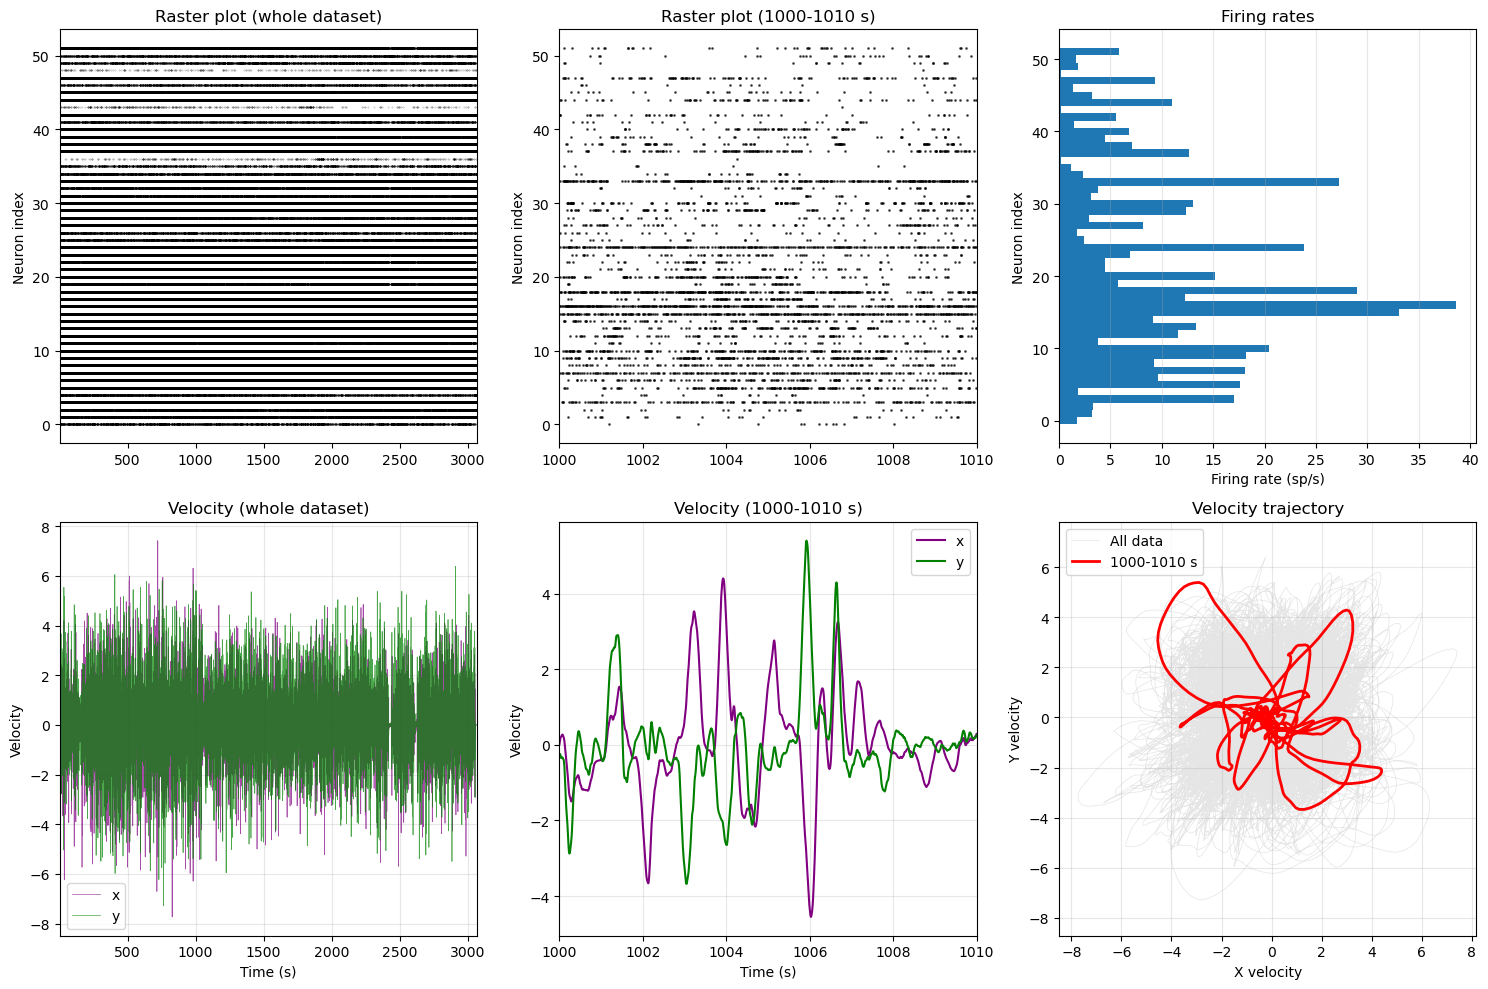

In [6]:
duration = vel_times[-1] - vel_times[0] #duration of the experiment
firing_rates = [len(st) / duration for st in spike_times] #firing rates for each neuron

# Filter spikes and velocities for the window 1000-1010 seconds
spikes_window = [st[(st >= 1000) & (st <= 1010)] for st in spike_times]
vel_window_mask = (vel_times >= 1000) & (vel_times <= 1010)
vel_window = vel[vel_window_mask]
vel_times_window = vel_times[vel_window_mask]

plt.figure(figsize=(15, 10))

# Plot all spikes (raster plot)
ax = plt.subplot(231)  
for neuron_idx, spike_train in enumerate(spike_times): #for each neuron
    if len(spike_train) > 0: #if the neuron has any spikes
        plt.scatter(spike_train, [neuron_idx] * len(spike_train), 
                   s=0.1, c='black', alpha=0.3) #plot the spikes as orange dots
plt.ylabel('Neuron index')
plt.title('Raster plot (whole dataset)')
plt.xlim(vel_times[0], vel_times[-1])

# Plot all x- and y- components of the velocities
plt.subplot(234, sharex=ax)
plt.plot(vel_times, vel[:, 0], label='x', color='purple', alpha=0.7, linewidth=0.5)
plt.plot(vel_times, vel[:, 1], label='y', color='green', alpha=0.7, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.legend(loc='best')
plt.title('Velocity (whole dataset)')
plt.grid(True, alpha=0.3)

# Plot spikes at times t=1000 to t=1010
ax2 = plt.subplot(232) 
for neuron_idx, spike_train in enumerate(spikes_window): #for each neuron
    if len(spike_train) > 0: #if the neuron has any spikes
        plt.scatter(spike_train, [neuron_idx] * len(spike_train), 
                   s=1, c='black', alpha=0.6) #plot the spikes as black dots
plt.ylabel('Neuron index')
plt.title('Raster plot (1000-1010 s)')
plt.xlim(1000, 1010)

# Plot velocities at times t=1000 to t=1010
plt.subplot(235, sharex=ax2) #plot the velocities   
plt.plot(vel_times_window, vel_window[:, 0], label='x', color='purple', linewidth=1.5) 
plt.plot(vel_times_window, vel_window[:, 1], label='y', color='green', linewidth=1.5) 
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.legend(loc='best')
plt.title('Velocity (1000-1010 s)')
plt.grid(True, alpha=0.3)

# Compute firing rates for each neuron and plot as a bar chart
plt.subplot(233) 
plt.barh(range(len(spike_times)), firing_rates, height=1)
plt.xlabel('Firing rate (sp/s)')
plt.ylabel('Neuron index')
plt.title('Firing rates')
plt.grid(True, alpha=0.3, axis='x')


plt.subplot(236)
plt.plot(vel[:, 0], vel[:, 1], 'darkgray', alpha=0.3, linewidth=0.5, label='All data')
# t=1000 to t=1010
plt.plot(vel_window[:, 0], vel_window[:, 1], 'red', linewidth=2, label='1000-1010 s')
plt.xlabel('X velocity')
plt.ylabel('Y velocity')
plt.title('Velocity trajectory')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
# plt.figure(figsize=(12, 5))

# # Plot all spikes
# ax = plt.subplot(231)
# # ...
# plt.ylabel('Neuron index')
# # Plot all x- and y- components of the velocities
# plt.subplot(234, sharex=ax)
# # ...
# plt.xlabel('Time (s)')
# plt.ylabel('velocity')
# plt.legend(loc='best')
# # Plot spikes at times t=1000 to t=1010
# ax = plt.subplot(232)
# # ...
# # Plot velocities at times t=1000 to t=1010
# plt.subplot(235, sharex=ax)
# plt.xlabel('Time (s)')

# # Compute firing rates for each neuron and plot as a histogram
# plt.subplot(233)
# firing_rates = ...
# plt.barh(range(len(spike_times)), firing_rates, height=1)
# plt.xlabel('Firing rate (sp/s)')
# plt.ylabel('Neuron index')

# # Plot all velocities as points in (x, y)-plane as a continuous curve
# # Emphasise the region from t=1000 to t=1010 with a different colour
# plt.subplot(236)
# # ...
# plt.xlabel('X velocity')
# plt.ylabel('Y velocity')

# plt.tight_layout();

## Task 2: Divide data into test/train and batches

In this section, you will divide the data up into non-overlapping test, train and (optionally) validation sets.

### Task 2A: Why not just use continuous time ranges?

In the Glaser et al. paper linked to above, they simply divide the range so that the first 70% of the data is used for training, the next 15% for validation and the last 15% for testing. This is a standard thing to do.

1. ⚠️ Compute the speeds from the velocity components, plot them and compute some statistics to show why this is a bad idea for this dataset. To make the plot clear, you might want to take averages over some window rather than plotting every point.

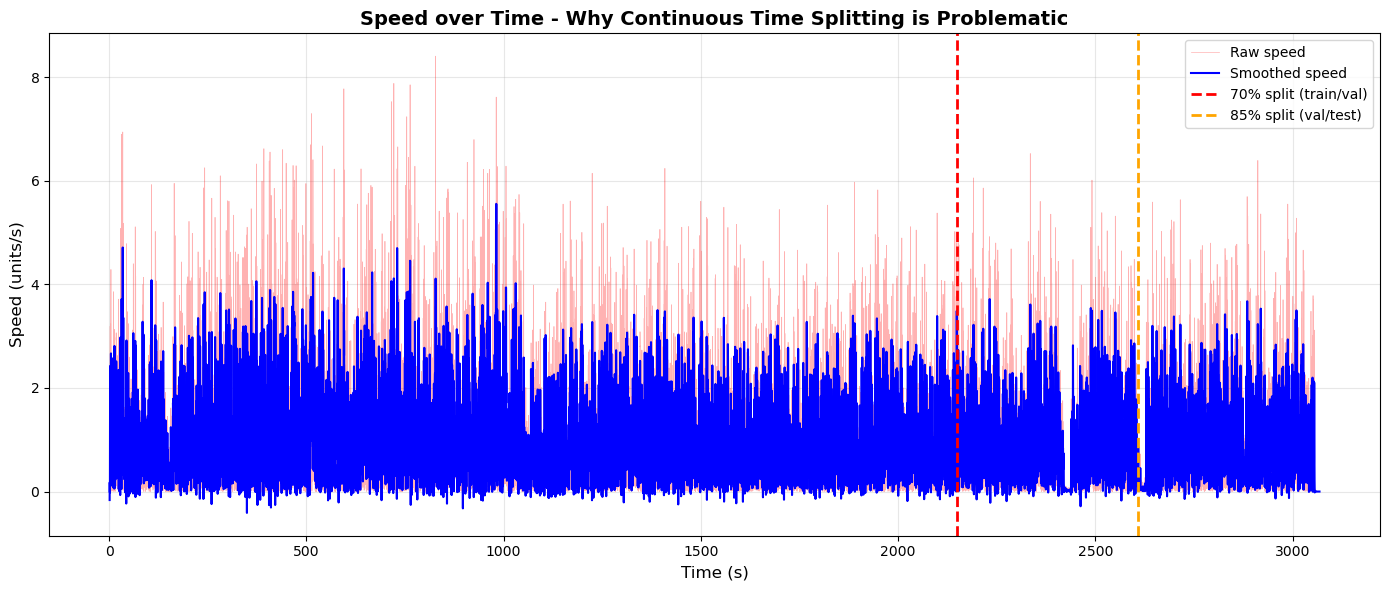

SPEED STATISTICS
Overall statistics:
  Mean speed: 1.0105 units/s
  Std speed:  0.9894 units/s
  Min speed:  0.0000 units/s
  Max speed:  8.4055 units/s
  Speed range: 8.4055 units/s
  Coefficient of variation (std/mean): 0.9790

Statistics for 70/15/15 time-based split:
  Training set (0-70%):   Mean = 1.0399 units/s
  Validation set (70-85%): Mean = 0.9294 units/s
  Test set (85-100%):      Mean = 0.9548 units/s

Difference between train and test means: 0.0851 units/s
Relative difference: 8.42%

EXPLANATION:
If we split the data by continuous time ranges (70/15/15), the training,
validation, and test sets will have different speed distributions.
This creates a distribution shift problem:
  - The model learns on one speed regime (e.g., slower movements)
  - But is tested on a different speed regime (e.g., faster movements)
  - This leads to poor generalization and biased performance estimates

Solution: Use equally distributed segments throughout the data so that
each set (train/val/t

In [7]:
# Task 2A: Compute speeds and show why continuous time splitting is problematic

# Compute speeds from velocity components
speed = np.sqrt(vel[:, 0]**2 + vel[:, 1]**2)

# Smooth the speed data using a moving average for clearer visualization
# Use a window size that corresponds to about 1 second of data
window_size = int(len(vel_times) / (vel_times[-1] - vel_times[0]))  # ~1 second window
if window_size % 2 == 0:
    window_size += 1  # Make odd for savgol_filter
if window_size < 5:
    window_size = 5  # Minimum window size

speed_smoothed = savgol_filter(speed, window_size, 3)  # 3rd order polynomial

# Plot speed over time
plt.figure(figsize=(14, 6))

# Plot raw speed (light, semi-transparent)
plt.plot(vel_times, speed, 'r-', alpha=0.3, linewidth=0.5, label='Raw speed')

# Plot smoothed speed (bold)
plt.plot(vel_times, speed_smoothed, 'b-', linewidth=1.5, label='Smoothed speed')

# Add vertical lines showing 70/15/15 split to illustrate the problem
total_time = vel_times[-1] - vel_times[0]
split_70 = vel_times[0] + 0.70 * total_time
split_85 = vel_times[0] + 0.85 * total_time

plt.axvline(x=split_70, color='r', linestyle='--', linewidth=2, label='70% split (train/val)')
plt.axvline(x=split_85, color='orange', linestyle='--', linewidth=2, label='85% split (val/test)')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Speed (units/s)', fontsize=12)
plt.title('Speed over Time - Why Continuous Time Splitting is Problematic', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute and print speed statistics
speed_mean = np.mean(speed)
speed_std = np.std(speed)
speed_min = np.min(speed)
speed_max = np.max(speed)

# Compute statistics for different time segments to show variation
train_end_idx = int(0.70 * len(speed))
val_end_idx = int(0.85 * len(speed))

train_speed_mean = np.mean(speed[:train_end_idx])
val_speed_mean = np.mean(speed[train_end_idx:val_end_idx])
test_speed_mean = np.mean(speed[val_end_idx:])

print("=" * 70)
print("SPEED STATISTICS")
print("=" * 70)
print(f"Overall statistics:")
print(f"  Mean speed: {speed_mean:.4f} units/s")
print(f"  Std speed:  {speed_std:.4f} units/s")
print(f"  Min speed:  {speed_min:.4f} units/s")
print(f"  Max speed:  {speed_max:.4f} units/s")
print(f"  Speed range: {speed_max - speed_min:.4f} units/s")
print(f"  Coefficient of variation (std/mean): {speed_std/speed_mean:.4f}")
print()
print(f"Statistics for 70/15/15 time-based split:")
print(f"  Training set (0-70%):   Mean = {train_speed_mean:.4f} units/s")
print(f"  Validation set (70-85%): Mean = {val_speed_mean:.4f} units/s")
print(f"  Test set (85-100%):      Mean = {test_speed_mean:.4f} units/s")
print()
print(f"Difference between train and test means: {abs(train_speed_mean - test_speed_mean):.4f} units/s")
print(f"Relative difference: {abs(train_speed_mean - test_speed_mean) / speed_mean * 100:.2f}%")
print("=" * 70)
print()
print("EXPLANATION:")
print("If we split the data by continuous time ranges (70/15/15), the training,")
print("validation, and test sets will have different speed distributions.")
print("This creates a distribution shift problem:")
print("  - The model learns on one speed regime (e.g., slower movements)")
print("  - But is tested on a different speed regime (e.g., faster movements)")
print("  - This leads to poor generalization and biased performance estimates")
print()
print("Solution: Use equally distributed segments throughout the data so that")
print("each set (train/val/test) contains samples from all speed regimes.")
print("=" * 70)


### Task 2B: use equally distributed segments for training, test and validation

1. ⚠️ Divide the data up into segments and use some fraction of these segments for training, test and validation, ensuring these segments do not overlap but that they are equally distributed throughout the data.
2. ⚠️ Write a generator function (see below) ``batched_data`` that iterates over your data in randomly ordered segments of a given length, returning it in batches. The function should have arguments that determine the fraction of the data to use, the simulation time step that will be used, the length (in seconds) of each batch, and the batch size (you may add additional arguments if you wish). The function should return a pair of arrays ``(x, y)``. The array ``x`` has shape ``(batch_size, num_neurons, num_time_points)`` containing the spike times as an array where a zero indicates no spike and 1 indicates a spike. Here ``num_time_points`` is the number of time points in the batch measured at the sampling rate of the simulation time step, not the number of time points in the data as a whole, nor at the spike or velocity sampling rate. The array ``y`` has shape ``(batch_size, 2, num_time_points)`` containing the velocities at the same time points as the spikes. You will need to use some sort of interpolation to get the velocities at these times.
3. ⚠️ Plot a sample of spike times and velocities for a random batch of length 1 second and ``batch_size=4``.

#### Note on generator functions

Generator functions are an advanced feature of Python that makes it easy to iterate over complicated datasets. The general syntax is just a standard function that uses the keyword ``yield`` instead of ``return`` to return data, which allows it to return data multiple times. You can iterate over the values returned by a generator function instead of just calling it. Here's an example:

In [8]:
def gimme_some_multiples(n):
    yield n*1
    yield n*2
    yield n*3

for x in gimme_some_multiples(3):
    print(x)

3
6
9


And another:

In [9]:
def gimme_some_more_multiples(n, how_many):
    for i in range(how_many):
        yield n*(i+1)

for x in gimme_some_more_multiples(5, 4):
    print(x)

5
10
15
20


#### Template

You can use the following template but you may want to define some additional helper functions to simplify your code and that you can re-use later.

In [ ]:
# # Template

# # Set up training / validation / testing ranges
# # ...

# # Generator function that yields batches
# def batched_data(range_to_use, dt=1e-3, length=1, batch_size=64):
#   pass # ...
#   for batch_idx in range(num_batches):
#     x = torch.zeros((batch_size, num_neurons, num_time_points))
#     y = torch.zeros((batch_size, 2, num_time_points))
#     for b in range(batch_size):
#       pass # ...
#     yield x, y

# # Plot a sample of data

# x, y = next(batched_data(...)) # this just gets the first item of an iterable

# plt.figure(figsize=(12, 5))
# for b in range(4):
#   # Plot spikes for this batch index
#   ax = plt.subplot(2, 4, b+1)
#   # ...
#   plt.ylabel('Neuron index')
#   plt.title(f'Batch index {b}')
#   # Plot velocities for this batch index
#   plt.subplot(2, 4, b+5, sharex=ax)
#   plt.xlabel('Time index')
#   plt.ylabel('velocity')
#   if b==0:
#     plt.legend(loc='best')
# plt.tight_layout();

Total segments: 3066
Train segments: 1022 (33.3%)
Val segments: 1022 (33.3%)
Test segments: 1022 (33.3%)

Generating sample batch...


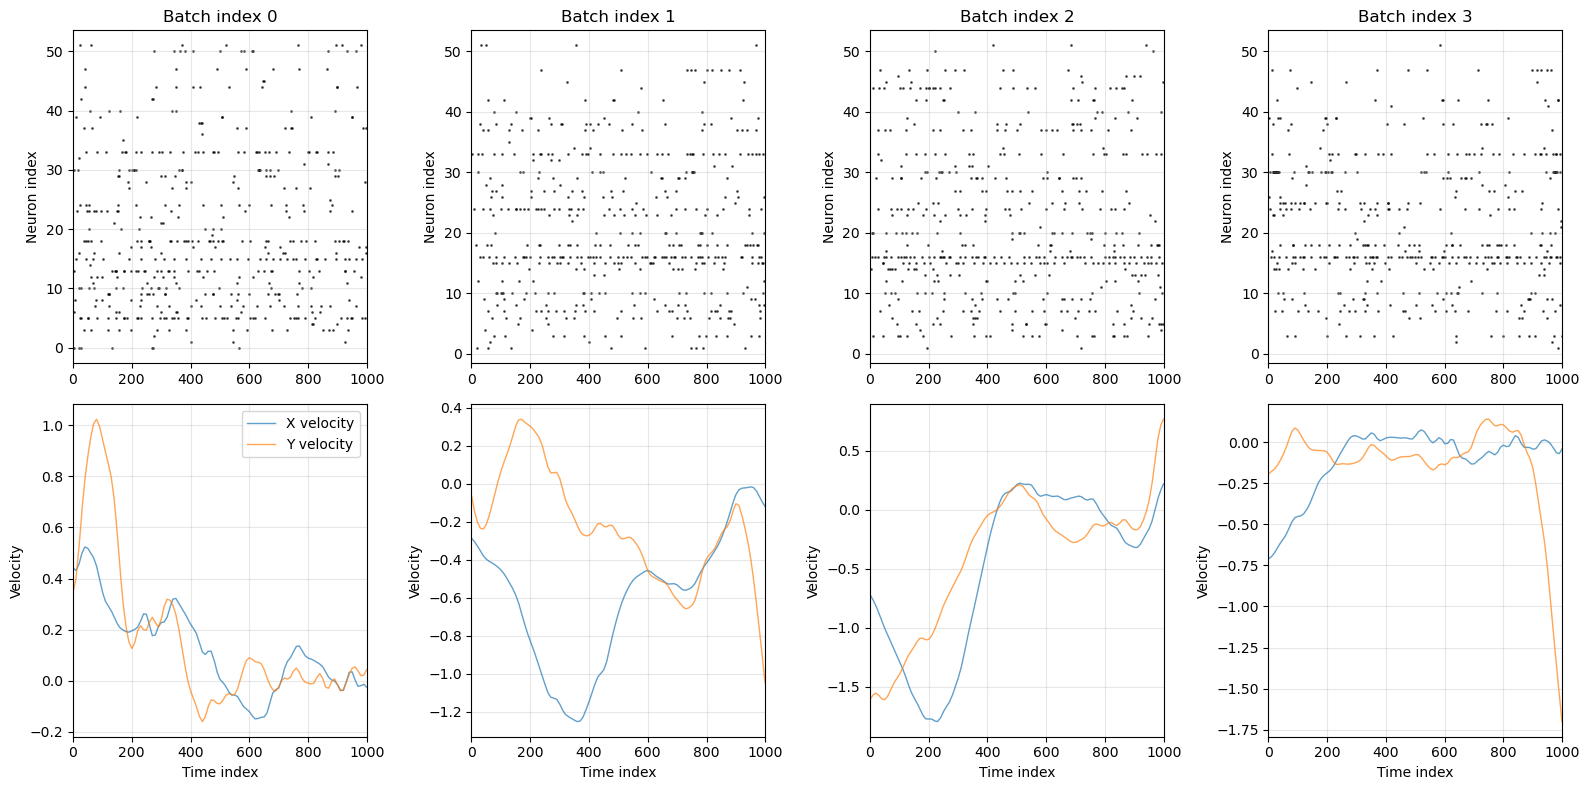


Batch shape: x=torch.Size([4, 52, 1000]), y=torch.Size([4, 2, 1000])
Number of spikes in batch: 1890


In [10]:
# Task 2B: Equally distributed segments and batched data generator

# Step 1: Divide data into equally distributed segments
# Get the total duration of the experiment
total_duration = vel_times[-1] - vel_times[0]
segment_length = 1.0  # 1 second segments
num_segments = int(total_duration / segment_length)

# Create segment time ranges
segments = []
for i in range(num_segments):
    start_time = vel_times[0] + i * segment_length
    end_time = min(start_time + segment_length, vel_times[-1])
    segments.append((start_time, end_time))

# Assign segments to train/val/test sets (equally distributed, not consecutive)
# Use modulo 3 to distribute: 0->train, 1->val, 2->test
train_segments = [i for i in range(num_segments) if i % 3 == 0]
val_segments = [i for i in range(num_segments) if i % 3 == 1]
test_segments = [i for i in range(num_segments) if i % 3 == 2]

# Adjust to approximately 70/15/15 split
# Calculate target sizes
target_train = int(0.70 * num_segments)
target_val = int(0.15 * num_segments)
target_test = num_segments - target_train - target_val

# Redistribute if needed (take from train to balance)
current_train = len(train_segments)
if current_train > target_train:
    excess = current_train - target_train
    # Move some segments from train to val/test
    for i in range(min(excess // 2, len(train_segments) - target_train)):
        if len(val_segments) < target_val:
            val_segments.append(train_segments.pop())
        elif len(test_segments) < target_test:
            test_segments.append(train_segments.pop())

print(f"Total segments: {num_segments}")
print(f"Train segments: {len(train_segments)} ({len(train_segments)/num_segments*100:.1f}%)")
print(f"Val segments: {len(val_segments)} ({len(val_segments)/num_segments*100:.1f}%)")
print(f"Test segments: {len(test_segments)} ({len(test_segments)/num_segments*100:.1f}%)")

# Create segment index mappings
train_ranges = [segments[i] for i in train_segments]
val_ranges = [segments[i] for i in val_segments]
test_ranges = [segments[i] for i in test_segments]

# Step 2: Generator function that yields batches
def batched_data(range_to_use, dt=1e-3, length=1, batch_size=64):
    """
    Generator function that yields batches of spike and velocity data.
    
    Args:
        range_to_use: List of (start_time, end_time) tuples for segments to use
        dt: Simulation time step (default 1ms)
        length: Length of each batch in seconds (default 1s)
        batch_size: Number of examples per batch (default 64)
    
    Yields:
        (x, y) tuple where:
        - x: torch.Tensor of shape (batch_size, num_neurons, num_time_points)
          Binary spike array (0 = no spike, 1 = spike)
        - y: torch.Tensor of shape (batch_size, 2, num_time_points)
          Velocities at simulation time points
    """
    num_time_points = int(length / dt)
    
    # Shuffle segments for random ordering
    import random
    shuffled_ranges = range_to_use.copy()
    random.shuffle(shuffled_ranges)
    
    # Process segments in batches
    for batch_start in range(0, len(shuffled_ranges), batch_size):
        batch_ranges = shuffled_ranges[batch_start:batch_start + batch_size]
        actual_batch_size = len(batch_ranges)
        
        # Initialize batch arrays
        x = torch.zeros((actual_batch_size, num_neurons, num_time_points))
        y = torch.zeros((actual_batch_size, 2, num_time_points))
        
        for b, (start_time, end_time) in enumerate(batch_ranges):
            # Create simulation time points for this batch
            sim_times = np.arange(start_time, start_time + length, dt)
            sim_times = sim_times[:num_time_points]  # Ensure correct length
            
            # Convert spike times to binary array
            for neuron_idx, neuron_spikes in enumerate(spike_times):
                # Find spikes within this time window
                mask = (neuron_spikes >= start_time) & (neuron_spikes < start_time + length)
                spikes_in_window = neuron_spikes[mask]
                
                # Convert spike times to time indices
                for spike_time in spikes_in_window:
                    time_idx = int((spike_time - start_time) / dt)
                    if 0 <= time_idx < num_time_points:
                        x[b, neuron_idx, time_idx] = 1.0
            
            # Interpolate velocities to simulation time points
            # Get velocities for x and y components
            y[b, 0, :] = torch.tensor(np.interp(sim_times, vel_times, vel[:, 0]), dtype=torch.float32)
            y[b, 1, :] = torch.tensor(np.interp(sim_times, vel_times, vel[:, 1]), dtype=torch.float32)
        
        yield x, y

# Step 3: Plot a sample batch
print("\nGenerating sample batch...")
x, y = next(batched_data(train_ranges, dt=1e-3, length=1, batch_size=4))

plt.figure(figsize=(16, 8))
for b in range(4):
    # Plot spikes for this batch index
    ax = plt.subplot(2, 4, b+1)
    spike_times_plot = []
    neuron_indices_plot = []
    for neuron_idx in range(num_neurons):
        spike_indices = torch.where(x[b, neuron_idx, :] > 0.5)[0]
        if len(spike_indices) > 0:
            spike_times_plot.extend(spike_indices.numpy())
            neuron_indices_plot.extend([neuron_idx] * len(spike_indices))
    
    if len(spike_times_plot) > 0:
        plt.scatter(spike_times_plot, neuron_indices_plot, s=1, c='k', alpha=0.6)
    plt.ylabel('Neuron index')
    plt.title(f'Batch index {b}')
    plt.xlim(0, x.shape[2])
    plt.grid(True, alpha=0.3)
    
    # Plot velocities for this batch index
    plt.subplot(2, 4, b+5, sharex=ax)
    time_indices = np.arange(x.shape[2])
    plt.plot(time_indices, y[b, 0, :].numpy(), label='X velocity', alpha=0.7, linewidth=1)
    plt.plot(time_indices, y[b, 1, :].numpy(), label='Y velocity', alpha=0.7, linewidth=1)
    plt.xlabel('Time index')
    plt.ylabel('Velocity')
    if b == 0:
        plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBatch shape: x={x.shape}, y={y.shape}")
print(f"Number of spikes in batch: {x.sum().item():.0f}")

Total segments: 3066
Train segments: 2148 (70.1%)
Val segments: 459 (15.0%)
Test segments: 459 (15.0%)

Generating sample batch...


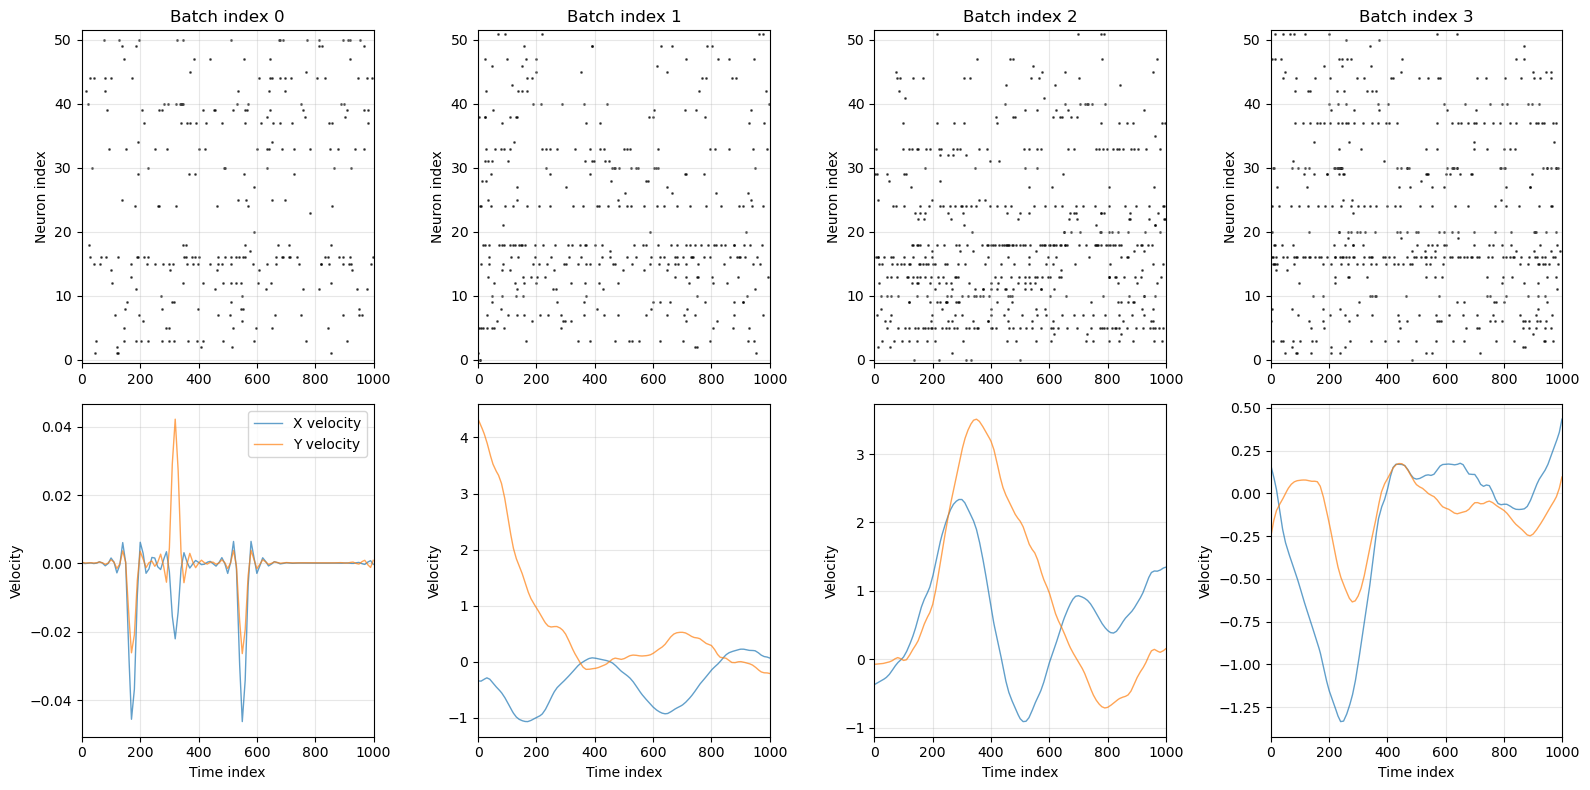


Batch shape: x=torch.Size([4, 52, 1000]), y=torch.Size([4, 2, 1000])
Number of spikes in batch: 1703

Example usage for training:
Total batches in one epoch: 33


In [11]:
import random


# Task 2B: Equally distributed segments and batched data generator

# Step 1: Divide data into equally distributed segments
# Get the total duration of the experiment
total_duration = vel_times[-1] - vel_times[0]
segment_length = 1.0  # 1 second segments
num_segments = int(total_duration / segment_length)

# Create segment time ranges
segments = []
for i in range(num_segments):
    start_time = vel_times[0] + i * segment_length
    end_time = min(start_time + segment_length, vel_times[-1])
    segments.append((start_time, end_time))

# Assign segments to train/val/test sets (equally distributed, not consecutive)
# Use round-robin distribution for 70/15/15 split
train_segments = []
val_segments = []
test_segments = []

for i in range(num_segments):
    # Every 20 segments: 14 train, 3 val, 3 test (70/15/15)
    pos = i % 20
    if pos < 14:
        train_segments.append(i)
    elif pos < 17:
        val_segments.append(i)
    else:
        test_segments.append(i)

print(f"Total segments: {num_segments}")
print(f"Train segments: {len(train_segments)} ({len(train_segments)/num_segments*100:.1f}%)")
print(f"Val segments: {len(val_segments)} ({len(val_segments)/num_segments*100:.1f}%)")
print(f"Test segments: {len(test_segments)} ({len(test_segments)/num_segments*100:.1f}%)")

# Create segment index mappings
train_ranges = [segments[i] for i in train_segments]
val_ranges = [segments[i] for i in val_segments]
test_ranges = [segments[i] for i in test_segments]

# Step 2: Generator function that yields batches
def batched_data(range_to_use, dt=1e-3, length=1, batch_size=64, shuffle=True, infinite=True):
    """
    Generator function that yields batches of spike and velocity data.
    
    Args:
        range_to_use: List of (start_time, end_time) tuples for segments to use
        dt: Simulation time step (default 1ms)
        length: Length of each batch in seconds (default 1s)
        batch_size: Number of examples per batch (default 64)
        shuffle: Whether to shuffle segments (default True)
        infinite: If True, cycles through data indefinitely; if False, stops after one pass
    
    Yields:
        (x, y) tuple where:
        - x: torch.Tensor of shape (batch_size, num_neurons, num_time_points)
          Binary spike array (0 = no spike, 1 = spike)
        - y: torch.Tensor of shape (batch_size, 2, num_time_points)
          Velocities at simulation time points
    """
    num_time_points = int(length / dt)
    
    while True:
        # Shuffle segments for random ordering
        shuffled_ranges = range_to_use.copy()
        if shuffle:
            random.shuffle(shuffled_ranges)
        
        # Process segments in batches
        for batch_start in range(0, len(shuffled_ranges), batch_size):
            batch_ranges = shuffled_ranges[batch_start:batch_start + batch_size]
            actual_batch_size = len(batch_ranges)
            
            # Skip incomplete batches at the end if they're too small
            if actual_batch_size < batch_size and batch_start > 0:
                continue
            
            # Initialize batch arrays
            x = torch.zeros((actual_batch_size, num_neurons, num_time_points))
            y = torch.zeros((actual_batch_size, 2, num_time_points))
            
            for b, (start_time, end_time) in enumerate(batch_ranges):
                # Create simulation time points for this batch
                sim_times = np.arange(start_time, start_time + length, dt)
                sim_times = sim_times[:num_time_points]  # Ensure correct length
                
                # Convert spike times to binary array
                for neuron_idx, neuron_spikes in enumerate(spike_times):
                    # Find spikes within this time window
                    mask = (neuron_spikes >= start_time) & (neuron_spikes < start_time + length)
                    spikes_in_window = neuron_spikes[mask]
                    
                    # Convert spike times to time indices
                    for spike_time in spikes_in_window:
                        time_idx = int((spike_time - start_time) / dt)
                        if 0 <= time_idx < num_time_points:
                            x[b, neuron_idx, time_idx] = 1.0
                
                # Interpolate velocities to simulation time points
                # Get velocities for x and y components
                y[b, 0, :] = torch.tensor(np.interp(sim_times, vel_times, vel[:, 0]), dtype=torch.float32)
                y[b, 1, :] = torch.tensor(np.interp(sim_times, vel_times, vel[:, 1]), dtype=torch.float32)
            
            yield x, y
        
        # If not infinite, break after one pass through the data
        if not infinite:
            break

# Step 3: Plot a sample batch
print("\nGenerating sample batch...")
x, y = next(batched_data(train_ranges, dt=1e-3, length=1, batch_size=4))

plt.figure(figsize=(16, 8))
for b in range(4):
    # Plot spikes for this batch index
    ax = plt.subplot(2, 4, b+1)
    spike_times_plot = []
    neuron_indices_plot = []
    for neuron_idx in range(num_neurons):
        spike_indices = torch.where(x[b, neuron_idx, :] > 0.5)[0]
        if len(spike_indices) > 0:
            spike_times_plot.extend(spike_indices.numpy())
            neuron_indices_plot.extend([neuron_idx] * len(spike_indices))
    
    if len(spike_times_plot) > 0:
        plt.scatter(spike_times_plot, neuron_indices_plot, s=1, c='k', alpha=0.6)
    plt.ylabel('Neuron index')
    plt.title(f'Batch index {b}')
    plt.xlim(0, x.shape[2])
    plt.ylim(-0.5, num_neurons - 0.5)
    plt.grid(True, alpha=0.3)
    
    # Plot velocities for this batch index
    plt.subplot(2, 4, b+5, sharex=ax)
    time_indices = np.arange(x.shape[2])
    plt.plot(time_indices, y[b, 0, :].numpy(), label='X velocity', alpha=0.7, linewidth=1)
    plt.plot(time_indices, y[b, 1, :].numpy(), label='Y velocity', alpha=0.7, linewidth=1)
    plt.xlabel('Time index')
    plt.ylabel('Velocity')
    if b == 0:
        plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBatch shape: x={x.shape}, y={y.shape}")
print(f"Number of spikes in batch: {x.sum().item():.0f}")

# Example: To iterate through one epoch of training data
print("\nExample usage for training:")
train_gen = batched_data(train_ranges, dt=1e-3, length=1, batch_size=64, infinite=False)
batch_count = 0
for x_batch, y_batch in train_gen:
    batch_count += 1
print(f"Total batches in one epoch: {batch_count}")

## Task 3: Spiking neural network model

In this task, you will write code to simulate a spiking neural network that can be trained using surrogate gradient descent, as in lectures. The neuron model will have some extra features beyond what you have seen in lectures and in the SPyTorch tutorial.

### Surrogate gradient descent spike function

Below is the code for the surrogate gradient descent function from lectures. You can use it as is, although note that there is a hyperparameter (scale) that you can experiment with if you choose.

In [12]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

### Task 3A: Single layer simulation code


⚠️ Write modular code to simulate a layer of leaky integrate-and-fire spiking neurons compatible with autodifferentiation with PyTorch. The new feature compared to what you have seen before is that the time constant parameter $\tau$ should be different for each neuron, and be trainable.

You can write your simulator as a function or class. My recommendation is to derive from the ``nn.Module`` class of PyTorch, but you can do it how you like. The code should accept an input batch of spikes ``x`` of shape ``(batch_size, num_input_neurons, num_time_points)`` and values 0 or 1 (as in the ``batched_data`` generator function above). The code should have the option to produce either spiking or non-spiking output. In both cases, the output should be an array ``y`` of shape ``(batch_size, num_output_neurons, num_time_points)``. In the case of spiking output, the values of ``y`` should be 0s and 1s, and in the case of non-spiking output they should be the membrane potential values. You may also want to write an additional class to handle multiple layers of spiking neural networks for subsequent tasks.

Your code should include initialisation of the weight matrices and time constants, and add additional hyperparameters for this initialisation. I used a spread of time constants from 20-100 ms for spiking neurons and from 200 to 1000 ms for non-spiking neurons and it worked OK, but I didn't do an extensive hyperparameter search and you can probably improve on this.

<!-- I would recommend approaching this and the following sections as follows:

1. Write simulation code for a single layer, non-spiking neural network first. This code is simpler and will train fast (under 3 minutes on Colab). Attempt as much of the remaining tasks as possible using only this.
2. Add the ability for spiking and test that your code produces reasonable output but don't try to train it yet.
3. Add the ability to plot spiking hidden layers and try to get a reasonable initialisation of the network.
4. Start training the spiking neural network. Your final run will probably take a long time to train but you should build up to that by seeing how well the training curves improve for fewer epochs, batch sizes, etc. -->

You can use the template below if you want to use the class-based approach.

You may also find it useful to write a class that chains together a group of layers for later parts of the courseowrk.

### Task 3B: Verify your code

You will verify your code by simulating a network consisting of:

* One (non-simulated) input neuron firing at a constant rate of 50 sp/s for a total duration of 1 second simulated with a time step of ``dt=1*ms``.
* Two simulated, spiking neurons which each receive spikes from the input neuron with a weight of 0.5. The two simulated neurons should have time constants of 20 ms and 100 ms.

You should:

1. ⚠️ Run the simulation, recording the membrane potentials and spike times of the simulated neurons.
2. ⚠️ Plot the membrane potentials and spike times of the simulated neurons. Print the spike counts of the neurons. The first neuron should not fire any spikes.
3. ⚠️ Write down an analytic solution for the first simulated neuron (that doesn't fire any spikes).
4. ⚠️ Plot your analytic solution on the same graph as the simulated one to show that it is approximately equal.

## Task 4: Evaluating fit to data

Now that we have our simulation code, we get back to fitting this model to data.

1. ⚠️ Write code that takes a network and testing set as input and returns the mean loss over the testing data. The loss is the mean squared error of the output of the network compared to the target data. You may also find it helpful to compute the null loss, which is the loss you would get if you just output all zeros. After training, you should be able to do better than this!
2. ⚠️ Write code that plots some of the internal outputs of the network, for example to show you the spikes produced by hidden layers, calculate their firing rates, etc.
3. ⚠️ Initialise a network with one hidden layer of 100 spiking neurons and one output layer of 2 non-spiking neurons. Run this on a random sample of the data of length 1 and plot the input spikes, hidden layer spikes, output x- and y-velocities, and the data x- and y-velocities. For each spiking layer compute the firing rates of each neuron and plot them as a histogram.

In the next task, you can use this to initialise your networks in a reasonable state. Hidden layers should fire spikes at rates that are not too low and not too high. I aimed for an average firing rate in the range 20-100 and it worked well, but you can experiment with other options. The output layer should give values that are roughly in the right range as the data (i.e. it shouldn't go to +/- 100 if the data is going to only +/- 4). If you look at the spike trains of your hidden layer and all the neurons at initialisation are doing exactly the same thing then it's probably not going to learn very well, so try out some different weight initialisations to see if you can do better.

Print the value of the loss (and optionally the null loss) for your untrained network, to give you an idea of the baseline.

You may want to wrap your evaluation code in a ``with`` statement like below to stop PyTorch from computing gradients when evaluating (unnecessary and expensive):

```python
with torch.no_grad():
    ...
    # whatever you do here won't compute any gradients
```

## Task 5: Training

At last, we get to the stage of training our network to fit the data.

Start with a network consisting of a single non-spiking output layer (i.e. spikes connected directly via a weight matrix to two non-spiking LIF neurons as output).

1. ⚠️ Find a good initialisation for this network that gives outputs roughly in the right range.
2. ⚠️ Write code to train your network to minimise the mean squared error between the output of your network and the recorded velocities. You will need to select an optimisation algorithm, learning rate, etc.
3. ⚠️ Train your network, plotting the loss curves for the training and validation data during training, and print out the test loss at the end.
4. ⚠️ Plot the output of your model and compare to the data for 8 randomly sampled time windows of length 1.

Don't worry too much about performance at the moment. You should be able to do better than the null loss, but you don't need to do hugely better. I get a null loss of around 1.04 and a test loss of around 0.55, but it's OK if you don't get such good results, and you may get much better results because I didn't do any hyperparameter searching.

You may want to use the following code as a starting point (it worked well enough for me but you can probably do better). On my desktop with CPU only, this took about two minutes to train.

In [ ]:
# # Training parameters
# lr = 0.001 # learning rate
# num_epochs = 10
# max_num_batches = 40
# length = 1
# batch_size = 32 # small batches worked better for me for some reason

# # Optimiser and loss function
# optimizer = torch.optim.Adam(..., lr=lr) # what should the first argument be?

# # Training
# loss_hist = []
# val_loss_hist = []
# with tqdm(total=num_epochs*max_num_batches) as pbar:
#   last_epoch_loss = val_loss = null_val_loss = None
#   for epoch in range(num_epochs):
#     local_loss = []
#     for x, y in batched_data(...):
#       # Run the network
#       y_out = net(x)
#       # Compute a loss
#       loss = mse(y_out, y)
#       local_loss.append(loss.item())
#       # Update gradients
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       # do something to ensure that taus remain positive, maybe set 1 ms as minimum value
#       pbar.update(1)
#       pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     last_epoch_loss = np.mean(local_loss)
#     val_loss, null_val_loss = evaluate_network(net, ...)
#     pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     loss_hist.append(last_epoch_loss)
#     val_loss_hist.append(val_loss)

# # Plot the loss function over time
# plt.semilogy(loss_hist, label='Testing loss')
# plt.semilogy(val_loss_hist, label='Validation loss')
# plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend(loc='best')
# plt.tight_layout()

# testing_loss, null_testing_loss = evaluate_network(net, testing_range, length=length, batch_size=batch_size)
# print(f'{testing_loss=}, {null_testing_loss=}')

# # Plot trained output
# plt.figure(figsize=(16, 6))
# with torch.no_grad():
#   for x, y in batched_data(..., batch_size=8, max_num_batches=1):
#     for b in range(8):
#       plt.subplot(2, 4, b+1)
#       y_out = net(x)
#       plt.plot(y_out[b, 0, :], ':C0', label='x_out')
#       plt.plot(y_out[b, 1, :], ':C1', label='y_out')
#       plt.plot(y[b, 0, :], '--C0', label='x')
#       plt.plot(y[b, 1, :], '--C1', label='y')
#       # Plot a smoothed version as well
#       plt.plot(savgol_filter(y_out[b, 0, :], 151, 3), '-C0', label='x_out (smooth)')
#       plt.plot(savgol_filter(y_out[b, 1, :], 151, 3), '-C1', label='y_out (smooth)')
#       plt.ylim(-5, 5)
# plt.tight_layout();

## Task 6: Longer length decoding

Your code above probably doesn't look great when plotted. That's partly because the outputs start at 0 but the data doesn't necessarily have to, so it takes a while for them to get in sync, and partly because on some intervals it will just do badly. To fix this, and to extend the fit to a longer range of data, in this task we only use the final timestep of each segment and compare to the data. Take a 15 second segment of testing data, and sample every 0.2 seconds to get 75 data points. For each data point, take a 1 second segment of time before this data point (these will be overlapping), run your simulation for that one second, and use the final time point of the simulated output as your prediction. Plot this compared to the real data for 8 different segments of 15 seconds.

This should look like a reasonable fit to the data. Congratulations, you have used raw spiking output of neurons recorded from a monkey's brain to predict what it was doing on a computer screen it was interacting with. That's a brain machine interface right here.

1. ⚠️ Implement the decoding plot and run it on your trained network.

You can use the template below to get you started.

Your results might look something like this:

![Fits](fits.png)

In [ ]:
# def decoding_plot(net, dt_decoding=0.2, decoding_start=1000, decoding_length=15, length=1, dt=1e-3, figdims=(4, 2)):
#     w_intervals = np.arange(decoding_start+length, decoding_start+length+decoding_length, dt_decoding)
#     batch_size_single = len(w_intervals)-1
#     num_time_points = int(np.round(length/dt))
#     nfx, nfy = figdims
#     nf = nfx*nfy
#     batch_size = nf*batch_size_single
#     nrows = nfy*2
#     ncols = nfx
#     with torch.no_grad():
#         x = torch.zeros((batch_size, num_neurons, num_time_points))
#         y = torch.zeros((batch_size, 2, num_time_points))
#         T = []
#         for b in range(batch_size):
#            w_start = decoding_start+dt_decoding*b
#            w_end = w_start+length
#            T.append(w_end)
#            # ... (copy data to x, y)
#         T = np.array(T)
#         y_out = ...
#         mean_mse = mse(y, y_out)
#         plt.figure(figsize=(ncols*3, nrows*2))
#         for nf_i in range(nf):
#             sp_x = nf_i % nfx
#             sp_y = nf_i // nfx
#             for i in range(2):
#                 plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y+i*ncols)
#                 # ...
#                 plt.ylim(-4, 4)
#                 if sp_x==0:
#                     plt.ylabel('Velocity')
#                 if 2*sp_y+i==nrows-1:
#                     plt.xlabel('Time (s)')
#                 if nf_i==0:
#                     plt.legend(loc='best')
#         plt.suptitle(f'{net.fname}: {mean_mse=:.3f}')
#         plt.tight_layout()

# decoding_plot(models['single_layer.pt'])

## Task 7: Comparing spiking and non-spiking

1. ⚠️ Now try training your network with at least one spiking hidden layer. Compare your results to the non-spiking version. Note that training times with a spiking hidden layer are likely to be much longer. My training time went up from 2 minutes to 30 minutes (with CPU only).
2. ⚠️ Plot the trained distribution of weights and time constants for both models.

You might find it interesting to compare the distribution of time constants you find for the spiking hidden layer with the results in our paper [Perez et al. 2021](https://neural-reckoning.org/pub_heterogeneity.html). Note: this is not required for credit, only for your interest.

Well done - you have made it to the end!